<a href="https://colab.research.google.com/github/Sciform/sciform-hwz-ai-in-controlling/blob/main/lecture_2/2_5_ts_07_forecasting_with_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with a CNN

## Setup

In [1]:
!pip install tensorflow==2.16.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Print Keras version
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.16.1
Keras version: 3.3.3


In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

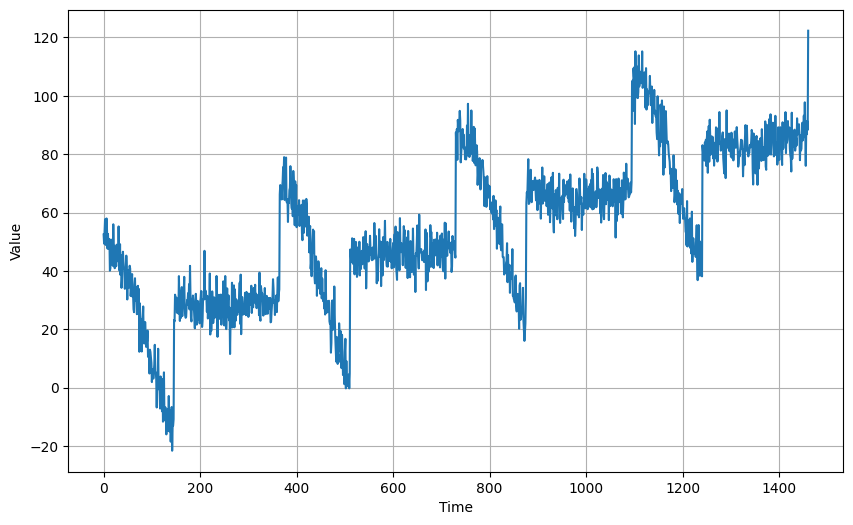

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Input(shape=[None, 1]),
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu"),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 65.8461 - mae: 66.3451 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 68.0538 - mae: 68.5528 - learning_rate: 1.1220e-08
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 65.3620 - mae: 65.8608 - learning_rate: 1.2589e-08
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 64.4883 - mae: 64.9873 - learning_rate: 1.4125e-08
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 62.3242 - mae: 62.8234 - learning_rate: 1.5849e-08
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 61.7925 - mae: 62.2915 - learning_rate: 1.7783e-08
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 60.4237 - mae: 60.9228 - learning_rate: 1.9953e-08
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 59.2104 - mae: 59.7094 - learning_rate: 2.2387e-08
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 57.0227 - mae: 57.5215 - learning_rate: 2.5119e-08
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 55.1609 - mae: 55.6595 - learning_rate: 2.8184e-08
Epoch 11/100
8/8 ━━━━━━━━━━━━━

(1e-08, 0.0001, 0.0, 30.0)

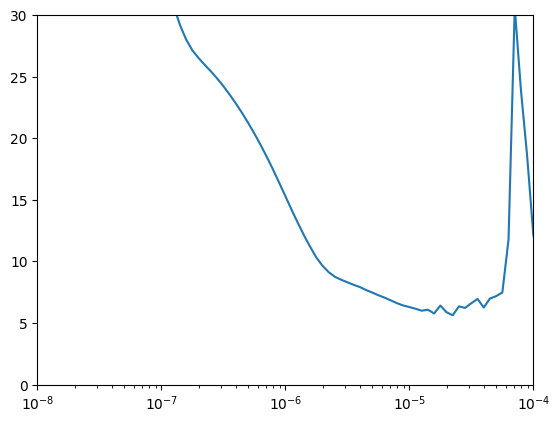

In [7]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Input(shape=[None, 1]),
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu"),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.keras", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 39.1169 - mae: 39.6142 - val_loss: 44.8183 - val_mae: 45.3178
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 14.7258 - mae: 15.2173 - val_loss: 21.1212 - val_mae: 21.6172
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.2503 - mae: 11.7393 - val_loss: 18.6803 - val_mae: 19.1750
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2714 - mae: 9.7586 - val_loss: 14.5824 - val_mae: 15.0769
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 7.6488 - mae: 8.1327 - val_loss: 9.2652 - val_mae: 9.7487
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.0482 - mae: 7.5298 - val_loss: 9.3427 - val_mae: 9.8258
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.4454 - mae: 6.9268 - val_loss: 9.2975 - val_mae: 9.7821
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.2682 - mae: 6.7493 - val_loss: 9.5994 - val_mae: 10.0857
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss:

In [9]:
model = keras.models.load_model("my_checkpoint.keras", safe_mode=False)

In [10]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


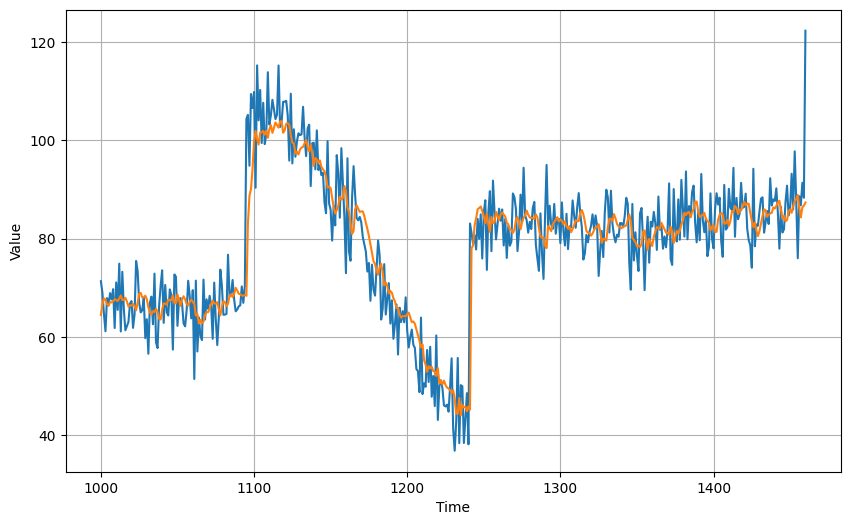

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.728988

## Fully Convolutional Forecasting

Convolutional Neural Networks are a special architecture of Deep Learning Models. Here we look specifically at the so-called wave-net architecture, which is particularly suitable fore time series forecasting. Except the new Neural Network architecture (and a slightly more suitable optimizer - Adam instead of SGD), everything is the same as in the "simple" approach!

### Learning Rate Scheduler

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64

# create data set
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

### DEEP NEURAL NETWERK ARCHITECTURE ###########################################
# create wave net CNN architecture
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[None, 1]))
# add a number of 1D Convolutional Layer with varying dilation to the network
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
# add a final layer with 1 filter
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
################################################################################

# setup learning rate scheduler
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

# here we do not use Stochastic Gradient Descent but the Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# setup model with loss function, optimizer and mean absolute error metr
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# train the model for different learning rate schedulers
lr_model = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - loss: 42.1238 - mae: 42.6227 - learning_rate: 1.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 41.6327 - mae: 42.1315 - learning_rate: 1.0798e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 40.8475 - mae: 41.3464 - learning_rate: 1.1659e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 41.6000 - mae: 42.0991 - learning_rate: 1.2589e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 41.1797 - mae: 41.6787 - learning_rate: 1.3594e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 40.2870 - mae: 40.7860 - learning_rate: 1.4678e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 39.3044 - mae: 39.8034 - learning_rate: 1.5849e-04
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 36.9482 - mae: 37.4468 - learning_rate: 1.7113e-04
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 35.5388 - mae: 36.0374 - learning_rate: 1.8478e-04
Epoch 10/100
8/8 ━━━━━━━━━

### Determine optimal learning rate

(0.0001, 0.1, 0.0, 30.0)

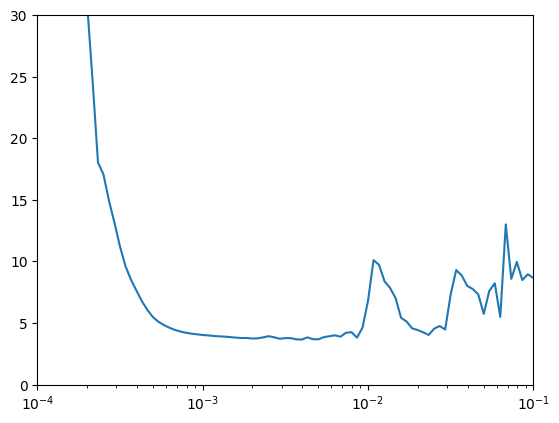

In [14]:
plt.semilogx(lr_model.history["learning_rate"], lr_model.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

# create Wave Net architecture
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# this saves the model to a file and we can load it later from file for our forecast without reruning the training
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.keras", save_best_only=True)

# training stops if now significant improvement after a "patience" of 50 epochs
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - loss: 39.1667 - mae: 39.6655 - val_loss: 24.6782 - val_mae: 25.1712
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 16.9381 - mae: 17.4317 - val_loss: 25.8198 - val_mae: 26.3180
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 12.1897 - mae: 12.6810 - val_loss: 10.5401 - val_mae: 11.0283
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.5949 - mae: 8.0792 - val_loss: 6.9710 - val_mae: 7.4542
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.6944 - mae: 6.1753 - val_loss: 6.4412 - val_mae: 6.9242
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.1087 - mae: 5.5874 - val_loss: 4.9531 - val_mae: 5.4302
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.5934 - mae: 5.0714 - val_loss: 4.5513 - val_mae: 5.0275
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.4518 - mae: 4.9296 - val_loss: 4.5838 - val_mae: 5.0611
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4

In [16]:
model = keras.models.load_model("my_checkpoint.keras", safe_mode=False)

In [17]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


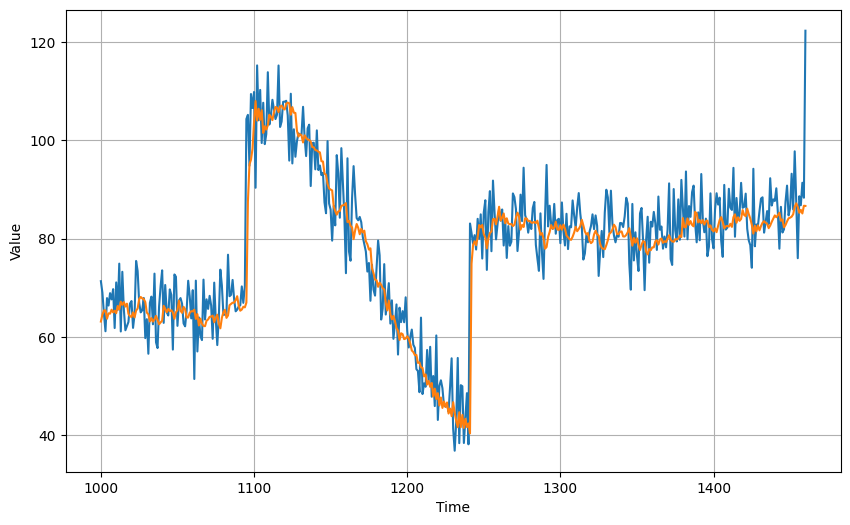

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [19]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.5977554

In [20]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# Source: https://github.com/tensorflow/examples